In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/NNDL/Project/ARDL

/content/drive/MyDrive/Colab Notebooks/NNDL/Project/ARDL


In [4]:
%load_ext autoreload
%autoreload 2

from dataset import *
from torch.utils.data import TensorDataset, DataLoader

In [5]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)


In [6]:
emb_mat, data = create_inp_data_and_weights(newsgroups_train, newsgroups_test, glove_dim=50)

Vocabulary size [Bag-of-words]:  151353
Vocabulary size [GloVe]:  400000


In [15]:
from cnn import *
input_size, emb_size = emb_mat.shape

model = build_random_cnn(3, 5, 128, 256, input_size, emb_size, 7, emb_mat)
model

CNN(
  (embedding): Embedding(151353, 50)
  (conv_layers): Sequential(
    (0): Conv1d(50, 201, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): BatchNorm1d(201, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (5): Conv1d(201, 185, kernel_size=(5,), stride=(1,), padding=(2,))
    (6): ReLU()
    (7): BatchNorm1d(185, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.5, inplace=False)
    (9): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (10): Conv1d(185, 149, kernel_size=(5,), stride=(1,), padding=(2,))
    (11): ReLU()
    (12): BatchNorm1d(149, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Dropout(p=0.5, inplace=False)
    (14): AdaptiveMaxPool1d(output_size=20)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(

In [16]:
learning_rate = 0.001
num_epochs = 15
batch_size = 512
display_step = 4

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [17]:
from torch.autograd import Variable

In [18]:
training_loss = []
validation_loss = []

total_batch = int(len(newsgroups_train.data)/batch_size)
    
total_batch_val = int(len(newsgroups_test.data)/batch_size)

for epoch in range(num_epochs):
    tr_loss = []
    model.train()

    total_batch = int(len(newsgroups_train.data)/batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_x,batch_y = get_batch(data['train'],i,batch_size)

        articles = Variable(torch.LongTensor(batch_x))
        labels = Variable(torch.LongTensor(batch_y))
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        _, outputs = model(articles)
        #print(outputs.shape, labels.shape)
        loss = criterion(outputs, labels)
        tr_loss.append(loss.data)
        loss.backward()
        optimizer.step()

    if (i+1) % display_step == 0:
        print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                %(epoch+1, num_epochs, i+1, len(newsgroups_train.data)//batch_size, sum(tr_loss)/total_batch))    
    
    model.eval()
    training_loss.append(sum(tr_loss)/total_batch)

    model.eval()
    # Loop over all batches
    batch_val_loss = []
    for i in range(total_batch_val):
        
        batch_x,batch_y = get_batch(data['test'],i,batch_size)

        articles = Variable(torch.LongTensor(batch_x))
        labels = Variable(torch.LongTensor(batch_y))

        _, y_test_pred = model(articles)
        
        test_loss = criterion(y_test_pred, labels)
        batch_val_loss.append(test_loss.data)

    if (i+1) % display_step == 0:
        print ('Epoch [%d/%d], Step [%d/%d], Val Loss: %.4f'
                %(epoch+1, num_epochs, i+1, len(newsgroups_train.data)//batch_size, sum(batch_val_loss)/total_batch_val))    

    validation_loss.append(sum(batch_val_loss)/total_batch_val)

Epoch [1/15], Step [4/22], Loss: 1.9169
Epoch [1/15], Step [8/22], Loss: 1.5439
Epoch [1/15], Step [12/22], Loss: 1.3752
Epoch [1/15], Step [16/22], Loss: 1.2921
Epoch [1/15], Step [20/22], Loss: 1.2529
Epoch [2/15], Step [4/22], Loss: 1.1381
Epoch [2/15], Step [8/22], Loss: 1.1420
Epoch [2/15], Step [12/22], Loss: 1.0683
Epoch [2/15], Step [16/22], Loss: 1.0076
Epoch [2/15], Step [20/22], Loss: 1.0366
Epoch [3/15], Step [4/22], Loss: 0.9558
Epoch [3/15], Step [8/22], Loss: 0.9759
Epoch [3/15], Step [12/22], Loss: 0.9269
Epoch [3/15], Step [16/22], Loss: 0.8739
Epoch [3/15], Step [20/22], Loss: 0.9038
Epoch [4/15], Step [4/22], Loss: 0.8590
Epoch [4/15], Step [8/22], Loss: 0.8945
Epoch [4/15], Step [12/22], Loss: 0.8281
Epoch [4/15], Step [16/22], Loss: 0.8113
Epoch [4/15], Step [20/22], Loss: 0.8209
Epoch [5/15], Step [4/22], Loss: 0.7783
Epoch [5/15], Step [8/22], Loss: 0.8428
Epoch [5/15], Step [12/22], Loss: 0.7705
Epoch [5/15], Step [16/22], Loss: 0.7349
Epoch [5/15], Step [20/22]

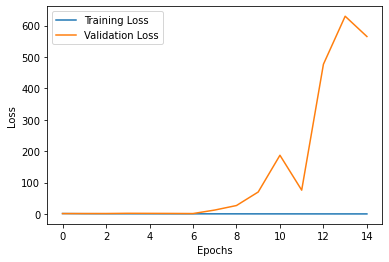

In [21]:
folder_name = 'models/cnn/model_2_10_03/'

from matplotlib import pyplot as plt
training_loss = np.array(training_loss)
validation_loss = np.array(validation_loss)


fig = plt.figure()
plt.plot(training_loss)
plt.plot(validation_loss)
plt.legend(["Training Loss", "Validation Loss"])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()
fig.savefig(folder_name + 'loss_vs_epoch.png')

In [22]:
total_batch = int(len(newsgroups_test.data)/batch_size)
correct = 0
total = 0
# Loop over all batches
for i in range(total_batch):
    batch_x,batch_y = get_batch(data['test'],i,batch_size)

    articles = Variable(torch.LongTensor(batch_x))
    labels = Variable(torch.LongTensor(batch_y))

    # Final validation accuracy
    total, correct = 0, 0
    model.eval()
    _, y_test_pred = model(articles)
    predicted = torch.argmax(y_test_pred, 1)

    total += y_test_pred.size(0)

    correct += (predicted == labels).sum()

print(f'Accuracy of the model is: {100*correct/total:.2f}%')

/Users/ayushi/Courses/Winter2022/nndl/project/ARDL/cnn.py:60: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return a, F.log_softmax(y)


Accuracy of the model is: 16.02%


In [43]:
# Additional information
PATH = folder_name + "model.pt"
LOSS = 0.3664
ACCURACY = 53.91

# Store model
torch.save({
            'accuracy': ACCURACY,
            'epoch': num_epochs,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

# Store model architecture
import pickle
file_name = folder_name + 'model_architecture.pickle'
with open(file_name, 'wb') as f:
    pickle.dump(model, f)